# Anomaly detection

In [1]:
# Remove sklearn annoying warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
from detector import *
from sklearn import svm
from sklearn import ensemble
from sklearn import neural_network
from sklearn import tree
import pickle

## Database loading

We use four files: CQA_Premium.csv, body.csv, moto.csv and moto2.csv.

We found 2 short databases with motorbikes measurements, so we load them separatly, and concatenate them.

In [3]:
# loading cars
cars = pd.read_csv("CQA_Premium.csv")\
          [['model_length_mm', 'model_width_mm']]\
          .rename(columns={
            'model_length_mm': 'length',
            'model_width_mm': 'width'
          })
cars.is_copy = False

cars.loc[:, 'class'] = "car"
# we remove some cars with really odd size
cars = cars[cars['width'] < 3000]
print('cars shape:\t{0}'.format(cars.shape))

# loading pedestrians
body = pd.read_csv("body.csv", sep=';')\
       [['shoulder.girth', 'chest.girth']]\
       .rename(columns={
           'shoulder.girth': 'width',
           'chest.girth': 'length'
       })
        
# converting cm to mm
body['width'] = body['width'].map(lambda x: 10 * float(x.replace(',', '.')))
body['length'] = body['length'].map(lambda x: 10 * float(x.replace(',', '.')))

body.is_copy = False
body.loc[:, 'class'] = "human"
print('body shape:\t{0}'.format(body.shape))

# loading motorbikes
moto1 = pd.read_csv("moto.csv", sep=';')\
        [['Overall length (mm)', 'Overall width (mm)']]\
        .rename(columns={
            'Overall length (mm)': 'length',
            'Overall width (mm)': 'width'
        }).dropna(0, 'any')

# converting to float
moto1['width'] = moto1['width'].map(lambda x: float(str(x).replace(' ', '')))
moto1['length'] = moto1['length'].map(lambda x: float(str(x).replace(' ', '')))

moto2 = pd.read_csv("moto2.csv", sep=';')\
        [['LARGHEZZA (mm)', 'LUNGHEZZA (mm)']]\
        .rename(columns={
            'LARGHEZZA (mm)': 'width',
            'LUNGHEZZA (mm)': 'length'
        })
        
moto2['width'] = moto2['width'].map(lambda x: float(str(x).replace(' ', '')))
moto2['length'] = moto2['length'].map(lambda x: float(str(x).replace(' ', '')))

# we remove a point at length ~20k that messes up the plot
# during concatenation
moto = moto1.append(moto2[moto2['length'] < 10000])

moto.is_copy = False
moto.loc[:, 'class'] = 'moto'
print('moto shape:\t{0}'.format(moto.shape))

cars shape:	(55261, 3)
body shape:	(507, 3)
moto shape:	(201, 3)


loaded 5646 rows (0.04 s)


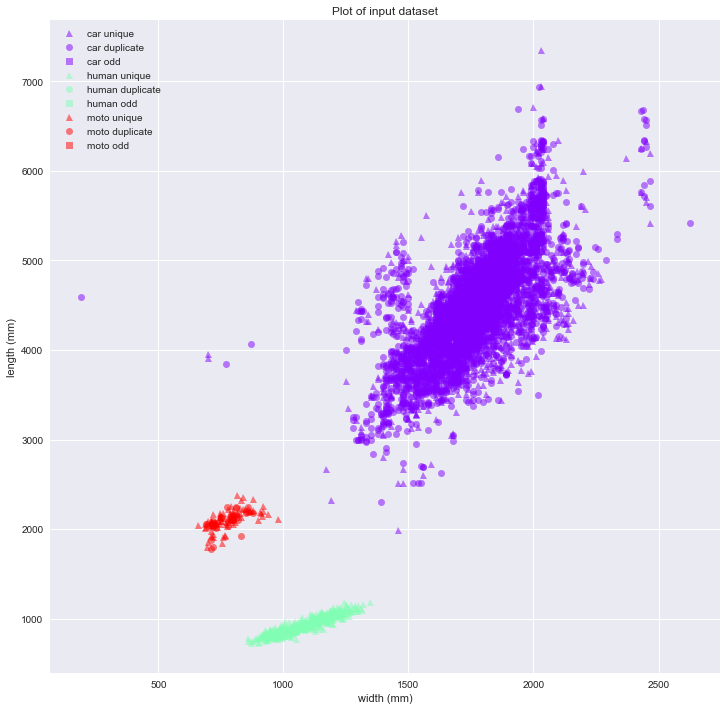

In [4]:
detector = Detector(cars.append(body).append(moto))
detector.plot()

## Malicious data generation

using seed: 1700852269


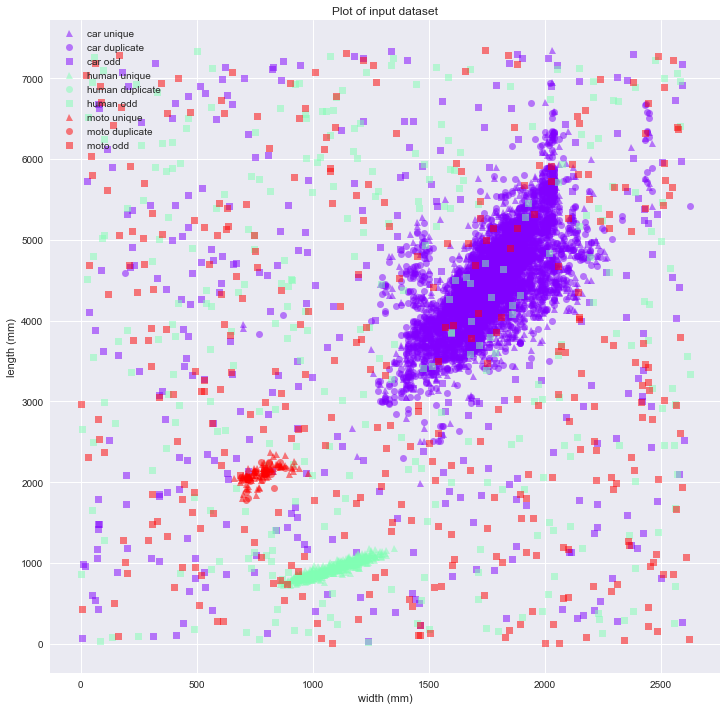

In [5]:
minx, maxx = 0, max(detector.df['width']) + 1
miny, maxy = 0, max(detector.df['length']) + 1
n = 1000
tmp = []
for k in range(n):
    tmp.append([rd.choice(list(set(detector.df['class']))),
                rd.randint(miny, maxy),
                rd.randint(minx, maxx)])
detector.append_odd_points(tmp)
detector.format()
detector.plot()

## Classification

Here we define the four classifiers we will work with. Parameters have been tuned thanks to the script [parameters.py](parameters.py).

In [6]:
classifiers = [
    neural_network.MLPClassifier(
        activation='tanh',
        solver='lbfgs',
        alpha=1e-06,
        learning_rate='constant',
        hidden_layer_sizes=(28, 28, 28)),
    ensemble.AdaBoostClassifier(
        tree.DecisionTreeClassifier(max_depth=3),
        n_estimators=46,
        learning_rate=.3),
    svm.LinearSVC(
        penalty='l1',
        dual=False,
        multi_class='crammer_singer',
        C=100,
        tol=.00001
    ),
    ensemble.RandomForestClassifier()
]

titles = (
    'perceptron   ',
    'adaboost     ',
    'svm          ',
    'random forest'
)

Now we compute the confusion matrix and the ratios of those classifiers.

In [7]:
results = {}
for clf, title in zip(classifiers, titles):
    results[title] = confusion_ratios(detector.classify(clf)[0])

for _ in range(len(titles[0])):
    print(' ', end='')
print('\tTPR\tFPR\tTNR\tFNR\tPPV\tF1')
for title in results.keys():
    print("{0}\t".format(title), end='')
    for x in results[title]:
        print('{0}\t'.format(round(x, 4)), end='')
    print()

             	TPR	FPR	TNR	FNR	PPV	F1
perceptron   	0.5677	0.0053	0.9947	0.4323	0.9493	0.7105	
adaboost     	0.9354	0.0103	0.9897	0.0646	0.9411	0.9382	
svm          	0.9657	1.0	0.0	0.0343	0.1446	0.2515	
random forest	0.9172	0.0067	0.9933	0.0828	0.9598	0.938	


Here is an example of decision boundaries for the AdaBoost classifier.

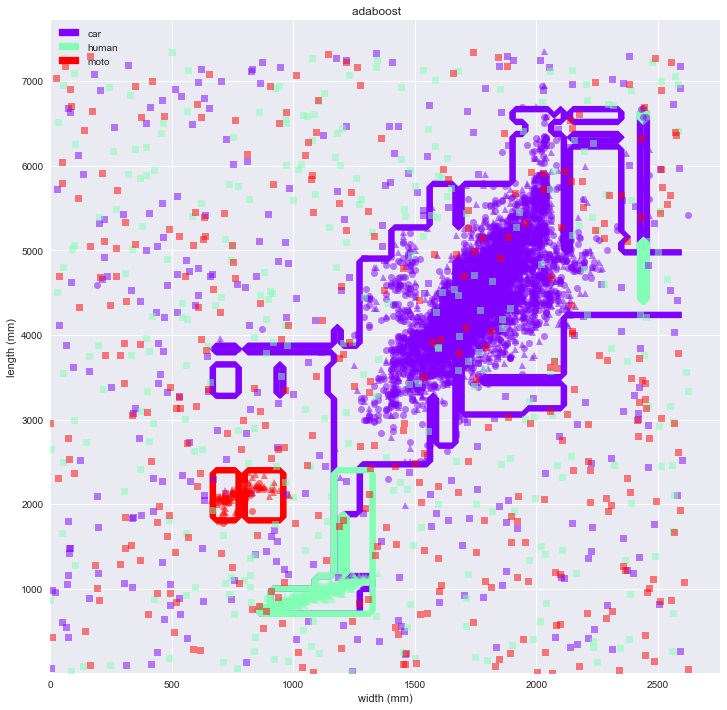

In [8]:
detector.plot_decision_boundaries(classifiers[1], titles[1])

## Usage in production

We start with our `Detector` that loads all the data we gathered. We feed it a classifier to train. We then store it back into the detector.

In [9]:
untrained_clf = ensemble.AdaBoostClassifier (
    base_estimator = tree.DecisionTreeClassifier(max_depth=3),
    n_estimators = 46,
    learning_rate = .3
)

trained_clf = detector.classify(untrained_clf)[2]
detector.best_clf = trained_clf

Now, we could use `detector.predict(class_, length, width)` for our predictions. But sharing the `Detector` object is not a good solution: it would also gather the (now useless) dataframes, other methods, etc. So instead, we just dump the method.

In [10]:
file = open('anomaly_classifier.clf', 'wb')
pickle.dump(detector.predict, file)
file.close()

### Usage

Now, we just have to load the function and apply it. The file is easily shared as it only weighs about 400 Kb.

In [11]:
def classify(class_, length, width):
    import pickle
    file = open('anomaly_classifier.clf', 'rb')
    fun = pickle.load(file)
    file.close()
    if fun(class_, length, width):
        return "malicious"
    else:
        return "non-malicous"

print("A moto 6 meters long and 1 meter wide:", classify("moto", 6000, 1000))
print("A car 5 meters long and 2 meter wide:", classify("car", 5000, 2000))

A moto 6 meters long and 1 meter wide: malicious
A car 5 meters long and 2 meter wide: non-malicous
